# Create Image Example
create an image of the zodiacal light as seen from an imager near earth

In [1]:
# move to the working directory
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [2]:
# import the necessary modules
import matplotlib.pyplot as plt
import numpy as np

from zodipol.utils.argparser import ArgParser
from zodipol.zodipol import Zodipol, Observation
from zodipol.background_radiation.integrated_starlight import IntegratedStarlight
from zodipol.visualization.skymap_plots import plot_satellite_image, plot_satellite_image_indices, plot_skymap_indices, plot_skymap

In [3]:
# magics
%reload_ext autoreload
%autoreload 2

In [4]:
parser = ArgParser(args=['-res', '300', '200', '--fov', '180', '-dir', '90', '40', '-par', '-ip', 'exposure_time', '10*u.s', '--isl', '--planetary'])

In [5]:
zodipol = Zodipol(polarizance=parser["polarizance"], fov=parser["fov"], n_polarization_ang=parser["n_polarization_ang"], parallel=parser["parallel"], n_freq=parser["n_freq"], planetary=parser["planetary"], isl=parser["isl"], resolution=parser["resolution"], imager_params=parser["imager_params"])

## Displaying the full-sky results

In [71]:
obs_full = zodipol.create_full_sky_observation(nside=64, obs_time=parser["obs_time"])

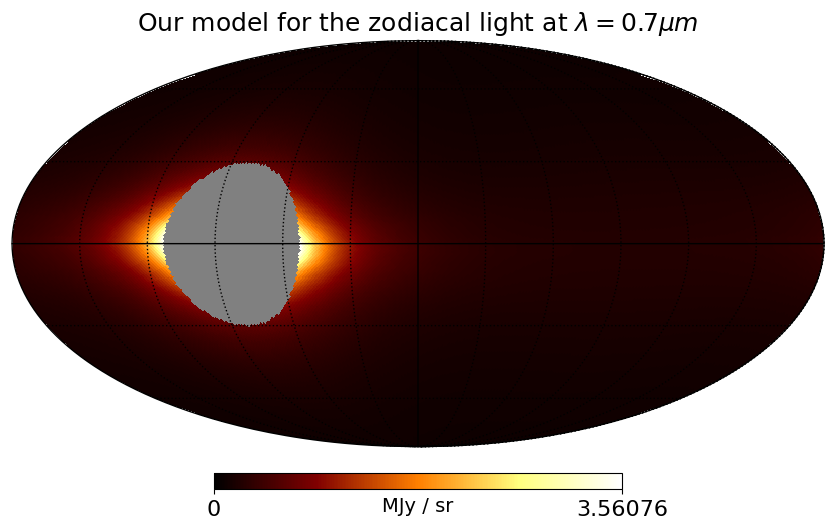

In [72]:
# Unpolarized intensity
binned_emission_unpol = obs_full.get_binned_emission(np.array(0), np.array(0))
# camera_intensity_unpol = zodipol.make_camera_images(obs_full, n_realizations=1, add_noise=False)
plot_skymap(2*binned_emission_unpol[:, 0, 0], min=0, title="Our model for the zodiacal light at $\lambda=0.7\mu m$", saveto='outputs/mie_fullsky_emission.pdf')

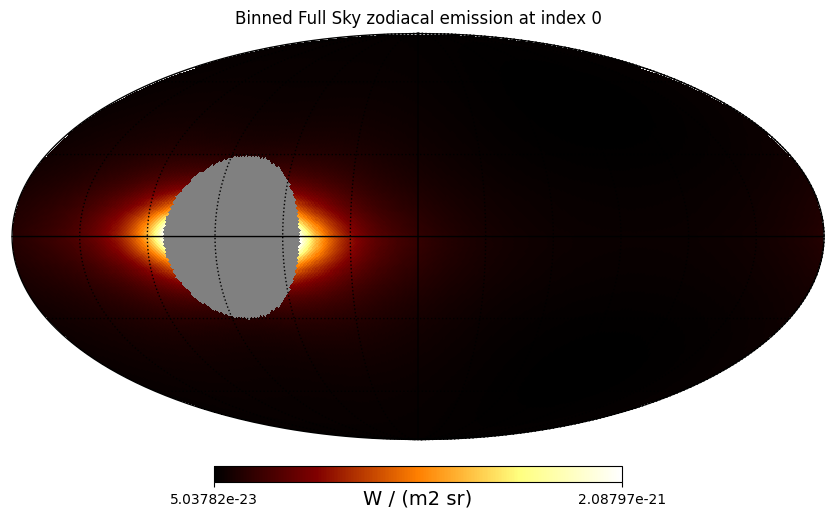

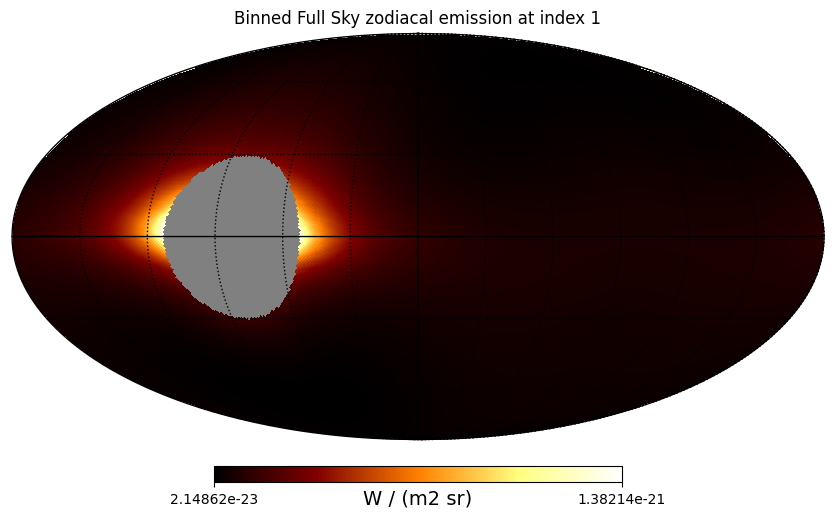

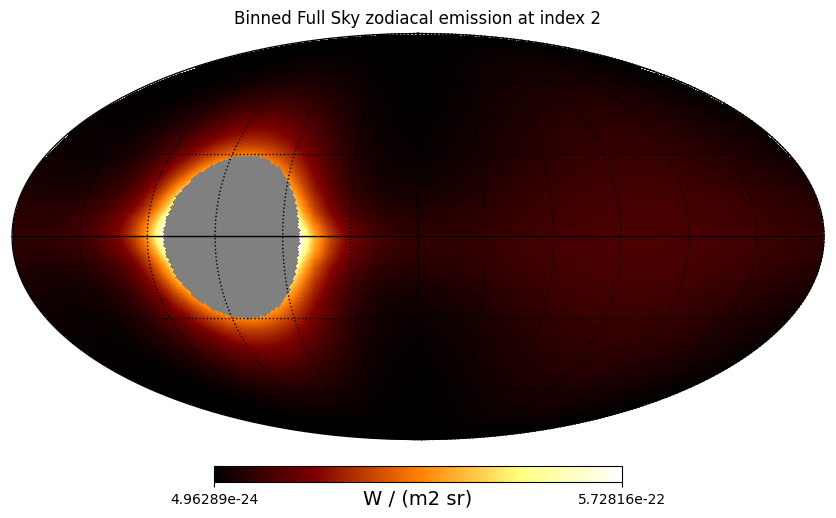

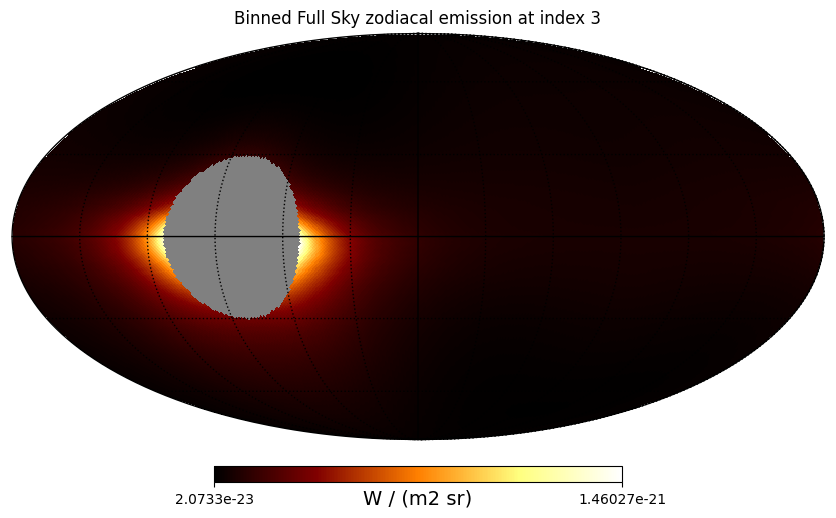

In [6]:
binned_emission_full = obs_full.get_binned_emission(parser["polarization_angle"], parser["polarizance"])
binned_dolp_full = obs_full.get_dolp()
binned_aop_full = obs_full.get_aop()

camera_intensity_full = zodipol.make_camera_images(obs_full, n_realizations=parser["n_realizations"], add_noise=False)
obs_camera_intensity_full = Observation.from_image(camera_intensity_full, parser["polarization_angle"])
camera_dolp = obs_camera_intensity_full.get_dolp()
camera_aop = obs_camera_intensity_full.get_aop()

plot_skymap_indices(camera_intensity_full[..., :], 4, title="Binned Full Sky zodiacal emission")

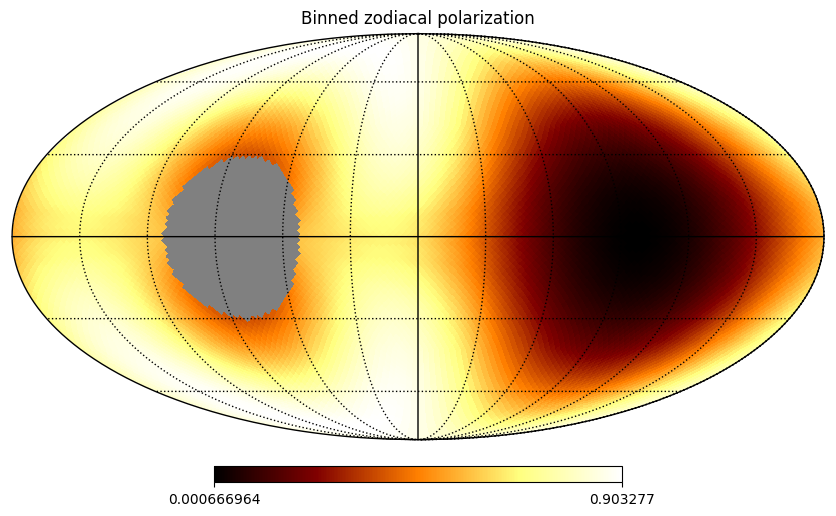

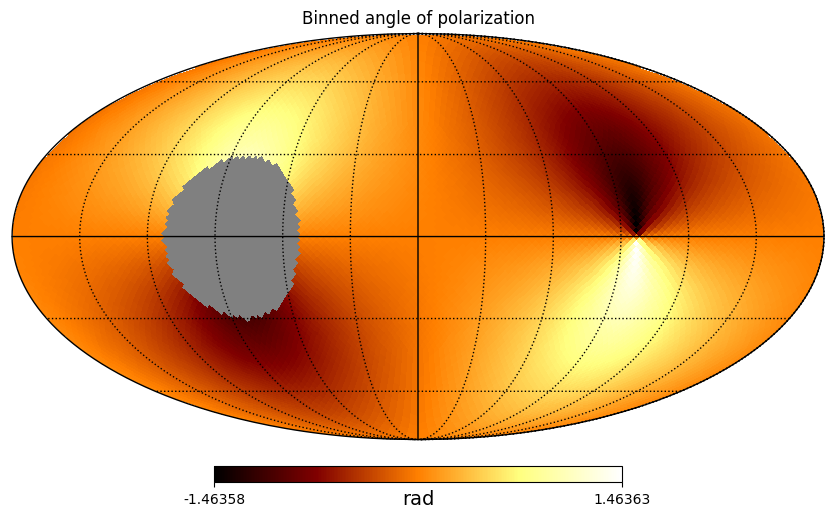

In [11]:
plot_skymap(binned_dolp_full[..., -1], title="Binned zodiacal polarization")
plot_skymap(binned_aop_full[..., -1], title="Binned angle of polarization")

## Noised image example

In [19]:
obs_f = zodipol.create_full_sky_observation(nside=64)

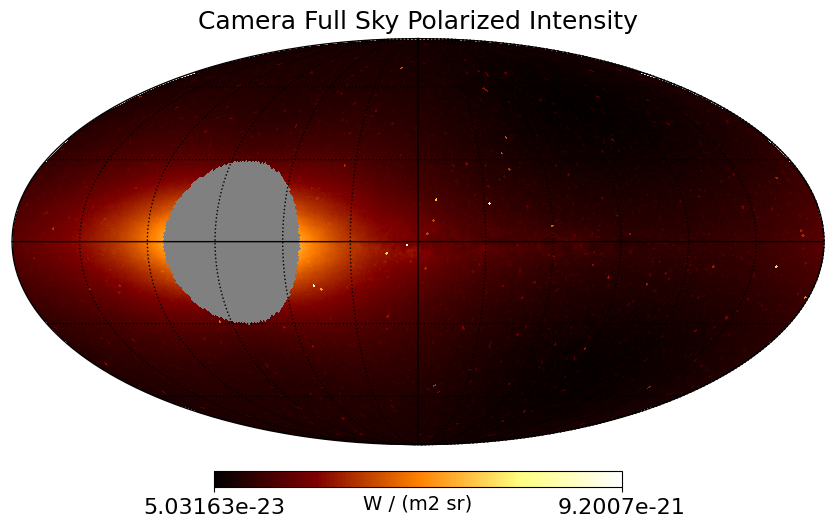

In [20]:
camera_intensity_f = zodipol.make_camera_images(obs_f, n_realizations=parser["n_realizations"], add_noise=True)


## Displaying Integrated Starlight results

In [6]:
import astropy.units as u

In [7]:
isl = IntegratedStarlight.load('saved_models/skymap_flux.npz')

In [8]:
isl.interpolate_freq(zodipol.frequency.to('Hz').value, update=True)

<Quantity [[ 7.64939852,  7.81856451,  7.9877305 , ..., 10.65503272,
            10.85365896, 11.0522852 ],
           [34.04284199, 34.69083397, 35.33882595, ..., 45.6330526 ,
            46.41138964, 47.18972669],
           [22.48061856, 22.97812776, 23.47563695, ..., 31.31568532,
            31.89884586, 32.48200639],
           ...,
           [ 5.54135649,  5.66070913,  5.78006177, ...,  7.65414924,
             7.79251938,  7.93088951],
           [ 9.76500971,  9.98289023, 10.20077075, ..., 13.63878408,
            13.89520108, 14.15161809],
           [27.32113217, 27.89425985, 28.46738754, ..., 37.4654562 ,
            38.12962356, 38.79379093]] nW / (m2 sr um)>

In [9]:
freq = isl.frequency * u.Hz
wavelength = freq.to(u.um, equivalencies=u.spectral())

In [10]:
f_differential = -np.gradient(wavelength) / np.gradient(freq).to('THz')

In [11]:
map = f_differential[-1] * isl.isl_map[..., -1].to('W / m2 sr um')
map_mjy = map.to('MJy / sr')

In [12]:
np.min(map_mjy), np.max(map_mjy)

(<Quantity 5.5945315e-05 MJy / sr>, <Quantity 121.1760356 MJy / sr>)

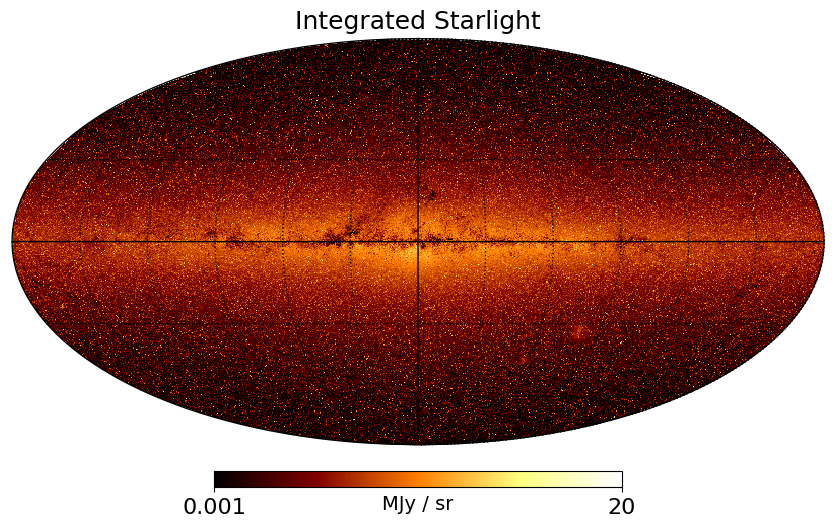

In [18]:
plot_skymap(map_mjy, title="Integrated Starlight", saveto='outputs/isl_fullsky.pdf', norm='log', min=1e-3, max=20)

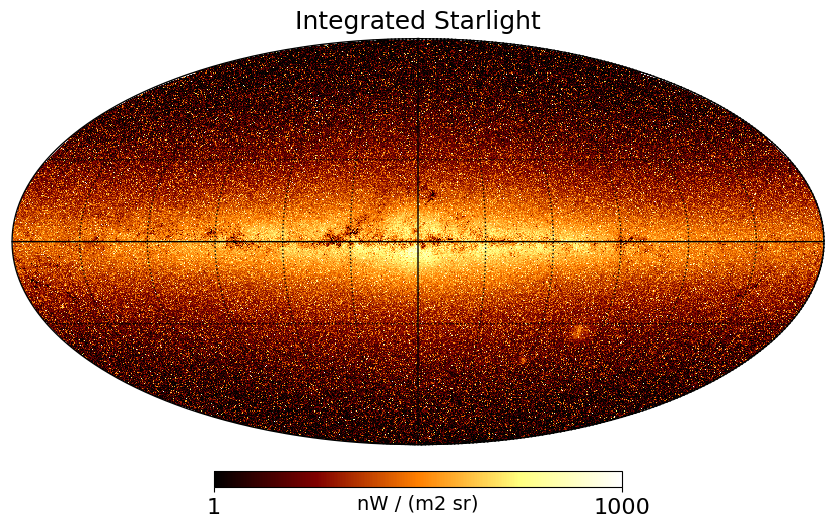

In [24]:
map_trapz = np.trapz(isl.isl_map, -wavelength, axis=-1)
plot_skymap(map_trapz, title="Integrated Starlight", norm='log', max=1000, min=1)

## Displaying the simulated results (per-frequency)

In [5]:
obs = zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], lonlat=False, new_isl=parser["new_isl"])

/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))


In [6]:
binned_emission = obs.get_binned_emission(parser["polarization_angle"], parser["polarizance"])
binned_dolp = obs.get_dolp()
binned_aop = obs.get_aop()

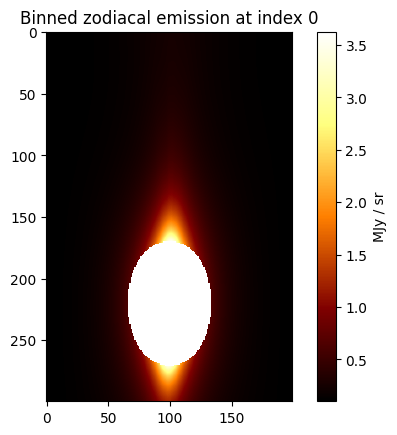

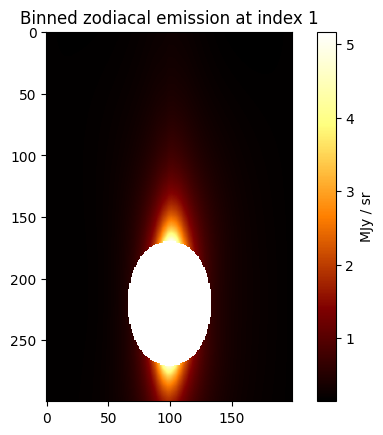

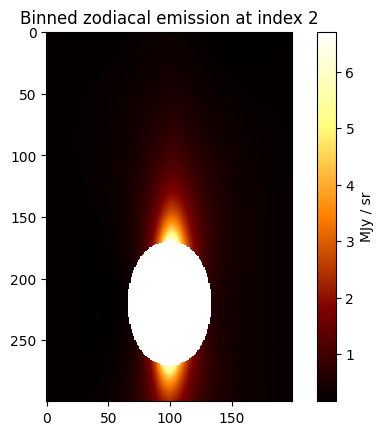

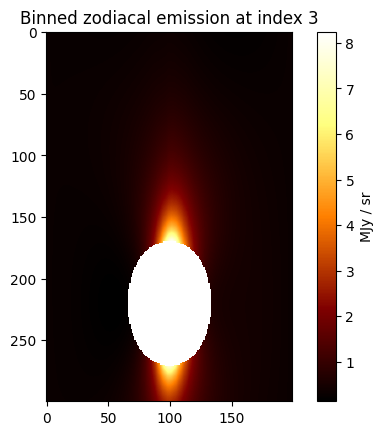

In [7]:
plot_satellite_image_indices(binned_emission[..., -1, :], 4, resolution=parser["resolution"], title="Binned zodiacal emission")

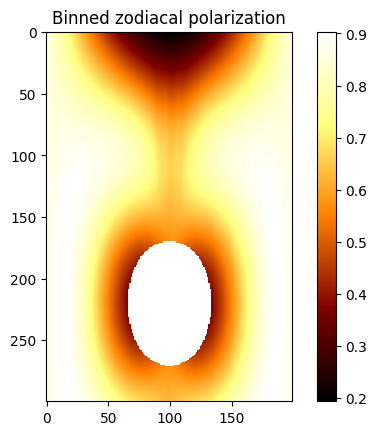

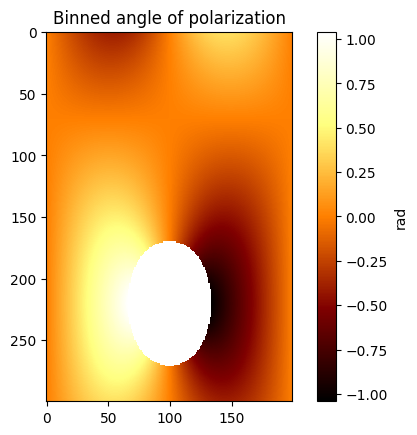

In [8]:
plot_satellite_image(binned_dolp[..., -1], resolution=parser["resolution"], title="Binned zodiacal polarization")
plot_satellite_image(binned_aop[..., -1], resolution=parser["resolution"], title="Binned angle of polarization")

# Displaying camera unnoised results

In [9]:
camera_intensity = zodipol.make_camera_images(obs, n_realizations=parser["n_realizations"], add_noise=False)
obs_camera_intensity = Observation.from_image(camera_intensity, parser["polarization_angle"])
camera_dolp = obs_camera_intensity.get_dolp()
camera_aop = obs_camera_intensity.get_aop()

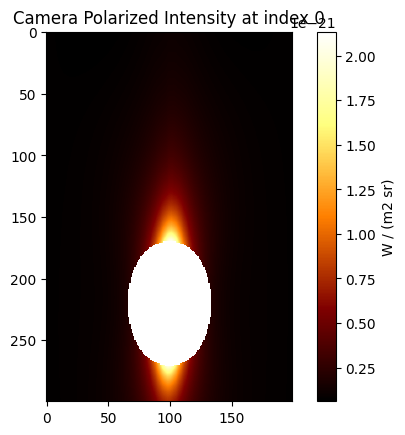

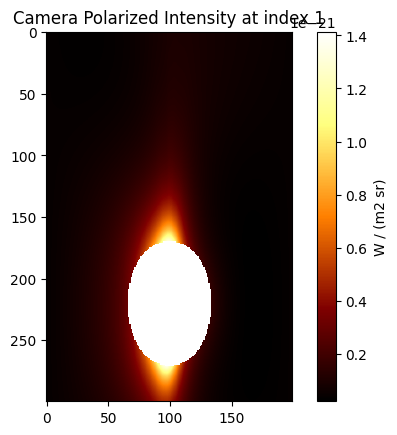

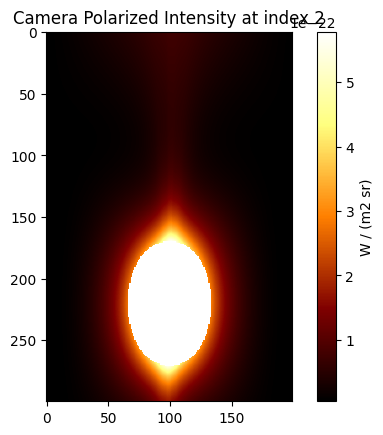

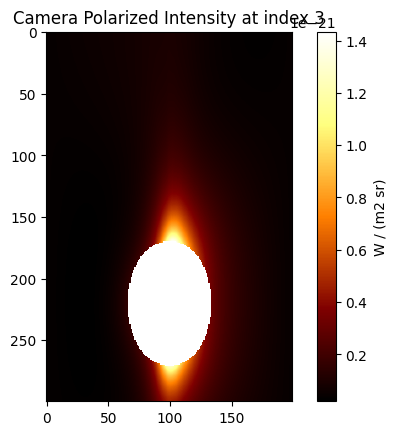

In [10]:
plot_satellite_image_indices(camera_intensity, 4, resolution=parser["resolution"], title="Camera Polarized Intensity")

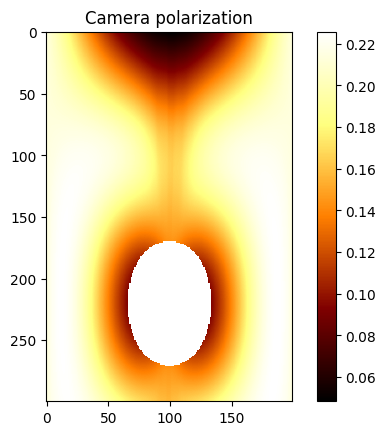

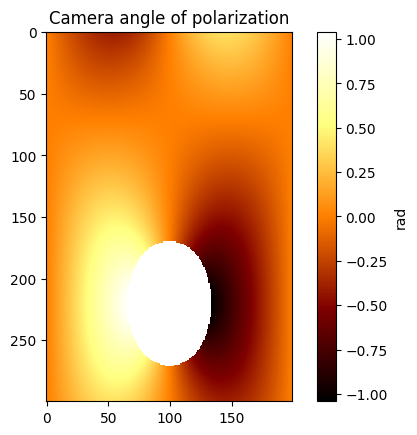

In [11]:
plot_satellite_image(camera_dolp, resolution=parser["resolution"], title="Camera polarization")
plot_satellite_image(camera_aop, resolution=parser["resolution"], title="Camera angle of polarization")

## Displaying camera noised results

In [12]:
camera_intensity_noise = zodipol.make_camera_images(obs, n_realizations=parser["n_realizations"], add_noise=True)
obs_camera_intensity_noise = Observation.from_image(camera_intensity_noise, parser["polarization_angle"])
camera_dolp_noise = obs_camera_intensity_noise.get_dolp()
camera_aop_noise = obs_camera_intensity_noise.get_aop()

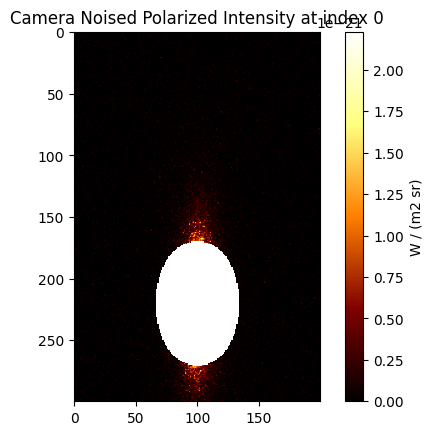

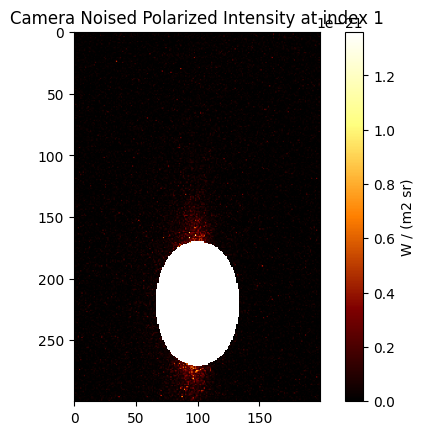

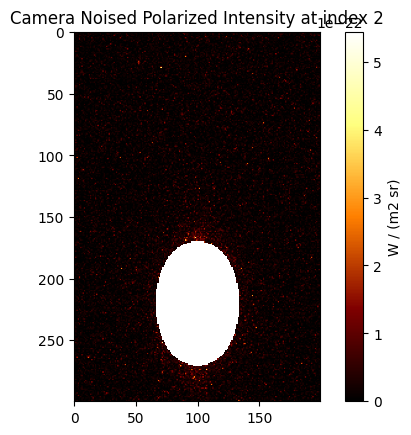

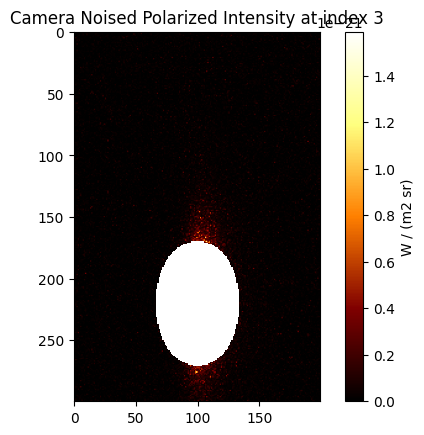

In [13]:
plot_satellite_image_indices(camera_intensity_noise, 4, resolution=parser["resolution"], title="Camera Noised Polarized Intensity")

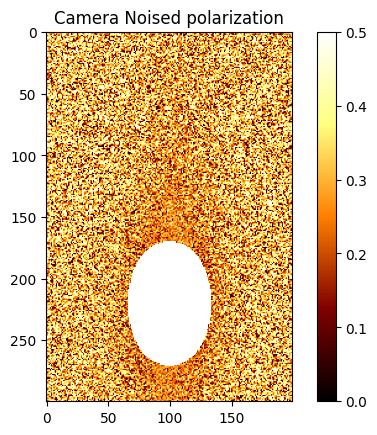

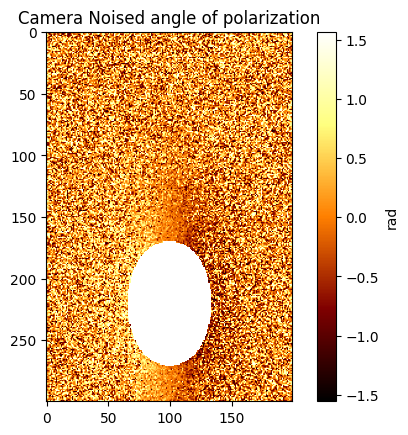

In [14]:
plot_satellite_image(camera_dolp_noise, resolution=parser["resolution"], title="Camera Noised polarization")
plot_satellite_image(camera_aop_noise, resolution=parser["resolution"], title="Camera Noised angle of polarization")